In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from numpy import mean
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Useful formatting functions and datas

In [35]:
def change_county(df):
    return df["COUNTY"] + " County"

def change_date_format(df):
    return df["DATE"][:3] + " "+ df["DATE"][7:11]

months = ['null','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_full = ['null', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_by_year = ['Jan 2019', 'Feb 2019', 'Mar 2019', 'Apr 2019', 'May 2019', 'Jun 2019', 'Jul 2019', 'Aug 2019', 'Sep 2019', 'Oct 2019', 'Nov 2019', 'Dec 2019',
                  'Jan 2020', 'Feb 2020', 'Mar 2020', 'Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020',
                  'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021', 'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021', 'Dec 20121']


#### Reading and formatting call 211 call data

In [36]:
call_counts = pd.read_csv("211_counts_v2.csv")
call_counts = call_counts.drop("Unnamed: 0", axis=1, inplace=False)
call_counts["DATE"] = call_counts.apply(lambda r:change_date_format(r), axis = 1)
call_counts["COUNTY"] = call_counts.apply(lambda x:change_county(x), axis = 1)
call_counts[call_counts["DATE"] == "Jul 2019"]

,COUNTY,DATE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,...,(Disaster) Contacts,(Disaster) Other disaster,(Other) Agency & other contact information,(Other) Community development & enrichment,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests
28,Buffalo County,Jul 2019,6,0,0,2,3,0,0,0,...,0,0,0,1,0,0,0,0,0,0
64,Iron County,Jul 2019,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81,Richland County,Jul 2019,9,8,3,2,1,1,1,0,...,0,0,2,0,0,0,0,0,0,1
88,Waukesha County,Jul 2019,85,31,11,47,235,11,10,3,...,1,0,33,3,1,6,2,6,0,9
110,Grant County,Jul 2019,6,5,6,6,8,3,3,1,...,0,0,2,0,0,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Shawano County,Jul 2019,6,1,1,3,5,2,0,0,...,0,2,0,0,0,1,0,0,0,2
1935,Dunn County,Jul 2019,9,4,7,2,7,5,2,1,...,0,1,1,0,0,1,0,1,0,2
1939,Eau Claire County,Jul 2019,38,9,15,20,37,9,4,4,...,0,3,3,4,3,7,0,8,0,15
1965,Ozaukee County,Jul 2019,8,1,1,3,7,0,1,0,...,0,0,2,0,0,0,0,0,0,1


#### Reading and Formatting cases data

In [37]:
years = [2019, 2020, 2021]
case_data = pd.DataFrame()
for year in years:
    month_data = pd.read_excel("data/"+str(year)+".xlsx", "Sheet1")
    year_data = pd.read_excel("data/"+str(year)+".xlsx", "Sheet2")
    year_data = year_data[:72]
    year_data = year_data[["County ", "Population *"]]
    year_data = year_data.rename(columns = {"County ": "COUNTY", "Population *": "Population"})
    for i in range(12):
        current_month = month_data[["Unnamed: 0", months_full[i+1], "Unnamed: "+ str((i+1)*2)]]
        current_month = current_month.rename(columns = {"Unnamed: 0": "COUNTY", months_full[i+1]: "Filled", "Unnamed: "+ str((i+1)*2): "Judgement"})
        current_month = current_month[1:73]
        current_month["COUNTY"] = current_month.apply(lambda x:change_county(x), axis = 1)
        current_month["DATE"] = months[i+1] +" "+str(year)
        current_month = current_month.merge(year_data, on = "COUNTY")
        frame = [case_data, current_month]
        case_data = pd.concat(frame)

case_data.head()


,COUNTY,Filled,Judgement,DATE,Population
0,Adams County,2,1,Jan 2019,20094
1,Ashland County,0,0,Jan 2019,15617
2,Barron County,6,2,Jan 2019,45229
3,Bayfield County,1,0,Jan 2019,14993
4,Brown County,69,29,Jan 2019,261368


## Statistic Plots

#### Line plot for total 211 calls from Aug 2019 to Oct 2021

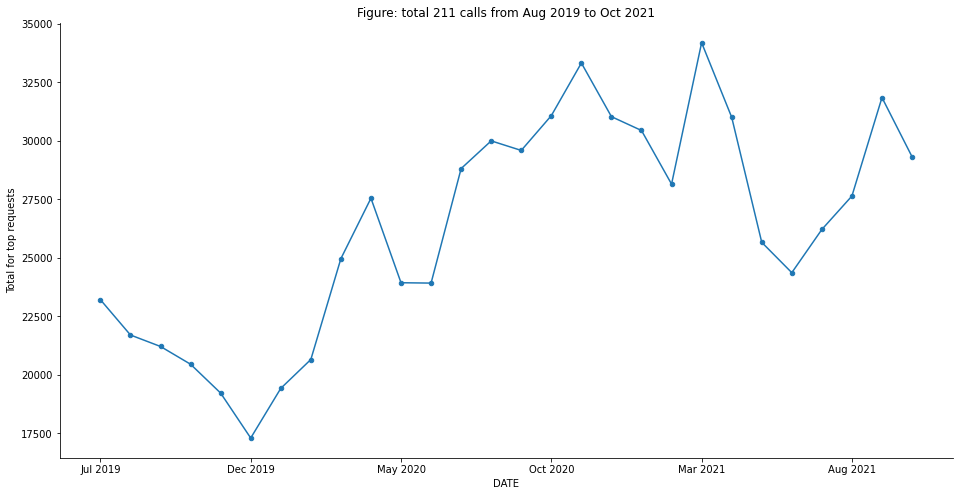

In [38]:
total_calls = call_counts[["COUNTY", "DATE","Total for top requests"]].groupby('DATE', as_index=False).sum()
total_calls['DATE'] = pd.Categorical(total_calls['DATE'], categories=months_by_year, ordered=True)
total_calls.sort_values(by='DATE',ascending=True,inplace=True)
ax_total_calls = total_calls.plot.line(x="DATE", y= "Total for top requests", legend = False, figsize = (16, 8))
total_calls.plot.scatter(ax = ax_total_calls, x="DATE", y= "Total for top requests", legend = False, figsize = (16, 8))
ax_total_calls.set_title("Figure: total 211 calls from Aug 2019 to Oct 2021")
ax_total_calls.spines["top"].set_visible(False)
ax_total_calls.spines["right"].set_visible(False)


#### Line plot for total 211 calls in Housing & Shelter category from Aug 2019 to Oct 2021

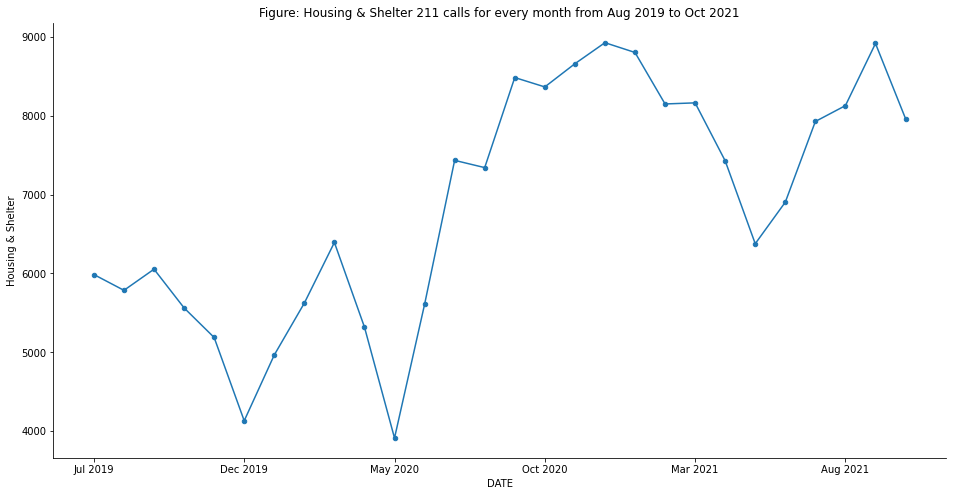

In [39]:
HS_calls = call_counts[["COUNTY", "DATE","Housing & Shelter"]].groupby('DATE', as_index=False).sum()
HS_calls['DATE'] = pd.Categorical(HS_calls['DATE'], categories=months_by_year, ordered=True)
HS_calls.sort_values(by='DATE',ascending=True,inplace=True)
ax_HS_calls = HS_calls.plot.line(x="DATE", y= "Housing & Shelter", legend = False, figsize = (16, 8))
HS_calls.plot.scatter(ax = ax_HS_calls, x="DATE", y= "Housing & Shelter", legend = False, figsize = (16, 8))
ax_HS_calls.set_title("Figure: Housing & Shelter 211 calls for every month from Aug 2019 to Oct 2021")
ax_HS_calls.spines["top"].set_visible(False)
ax_HS_calls.spines["right"].set_visible(False)

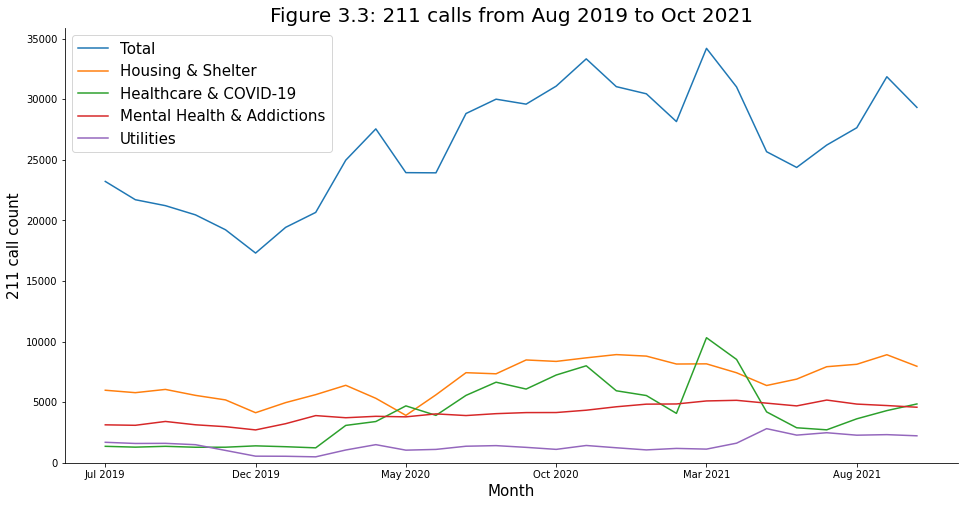

In [71]:
total_calls = call_counts[["COUNTY", "DATE","Total for top requests", "Housing & Shelter", "Healthcare & COVID-19", "Mental Health & Addictions", "Utilities"]].groupby('DATE', as_index=False).sum()
total_calls = total_calls.rename(columns={"Total for top requests": "Total"})
total_calls['DATE'] = pd.Categorical(total_calls['DATE'], categories=months_by_year, ordered=True)
total_calls.sort_values(by='DATE',ascending=True,inplace=True)
combined = total_calls.plot.line(x="DATE", y= ["Total", "Housing & Shelter", "Healthcare & COVID-19", "Mental Health & Addictions", "Utilities"], figsize = (16, 8))
# total_calls.plot.scatter(ax = combined, x="DATE", y= "Total for top requests", legend = False, figsize = (16, 8))
# total_calls.plot.scatter(ax = combined, x="DATE", y= "Housing & Shelter", legend = False, figsize = (16, 8), color = "orange")
combined.set_title("Figure: total 211 calls from Aug 2019 to Oct 2021")
combined.spines["top"].set_visible(False)
combined.spines["right"].set_visible(False)
combined.set_ylim(0)
combined.set_ylabel("211 call count", fontsize= 15)
combined.set_xlabel("Month", fontsize= 15)
combined.set_title("Figure 3.3: 211 calls from Aug 2019 to Oct 2021", fontsize=20)
combined.legend(fontsize=15, loc='upper left')

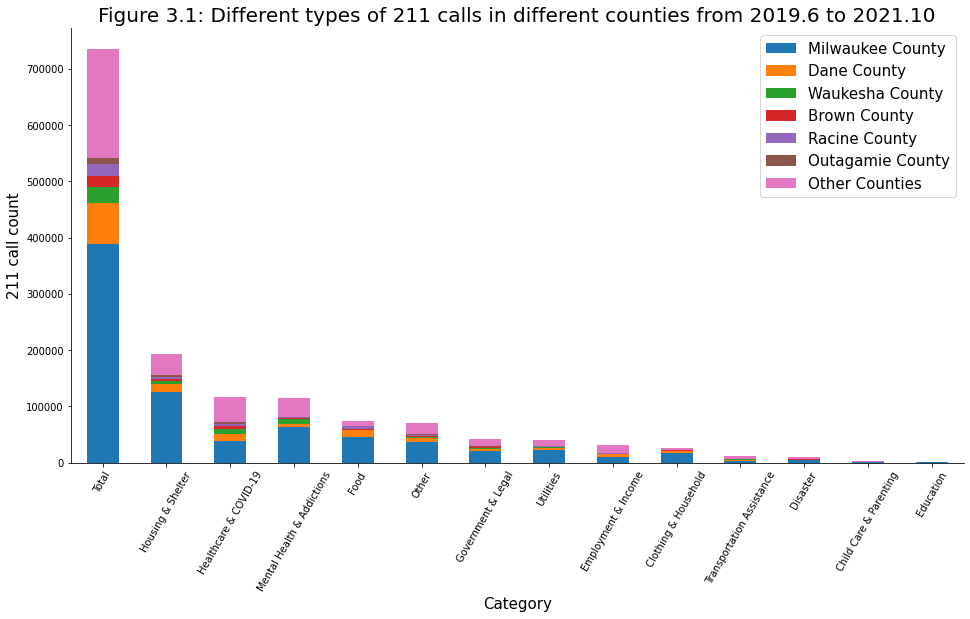

In [81]:
total_calls_by_county = call_counts.groupby('COUNTY', as_index=False).sum()
selected_county = ["Milwaukee County", "Dane County", "Waukesha County", "Brown County", "Racine County", "Outagamie County"]
result_df = pd.DataFrame()
for county in selected_county:
    current_frame = total_calls_by_county[total_calls_by_county["COUNTY"] == county]
    current_index = total_calls_by_county[total_calls_by_county["COUNTY"] == county].index
    total_calls_by_county = total_calls_by_county.drop(current_index)
    frames = [result_df, current_frame]
    result_df = pd.concat(frames)
def change_county_other(df):
    return "Other Counties"

total_calls_by_county["COUNTY"] = call_counts.apply(lambda x:change_county_other(x), axis = 1)
total_calls_by_county = total_calls_by_county.groupby("COUNTY", as_index = False).sum()
total_calls_by_county.reset_index(drop=True, inplace=True)
result_df.reset_index(drop=True, inplace=True)
frames = [result_df, total_calls_by_county]
result_df = pd.concat(frames, axis=0,ignore_index=True)
Big_categories = result_df.iloc[:,:15]
Big_categories.set_index(["COUNTY"], inplace = True)
Big_categories = Big_categories.rename(columns={"Total for top requests": "Total"})
Big_categories = Big_categories.T
Big_categories["All"] = Big_categories.apply(lambda x:x.sum(),axis =1)
ax = Big_categories.sort_values('All', ascending=False)[["Milwaukee County", "Dane County", "Waukesha County",
                  "Brown County", "Racine County", "Outagamie County", "Other Counties"]].plot(kind="bar", stacked=True, figsize=(16,8))
ax.set_title("Figure 3.1: Different types of 211 calls in different counties from 2019.6 to 2021.10", fontsize=20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
ax.set_ylabel("211 call count", fontsize= 15)
ax.set_xlabel("Category", fontsize= 15)
ax.legend(fontsize=15, loc='upper right')

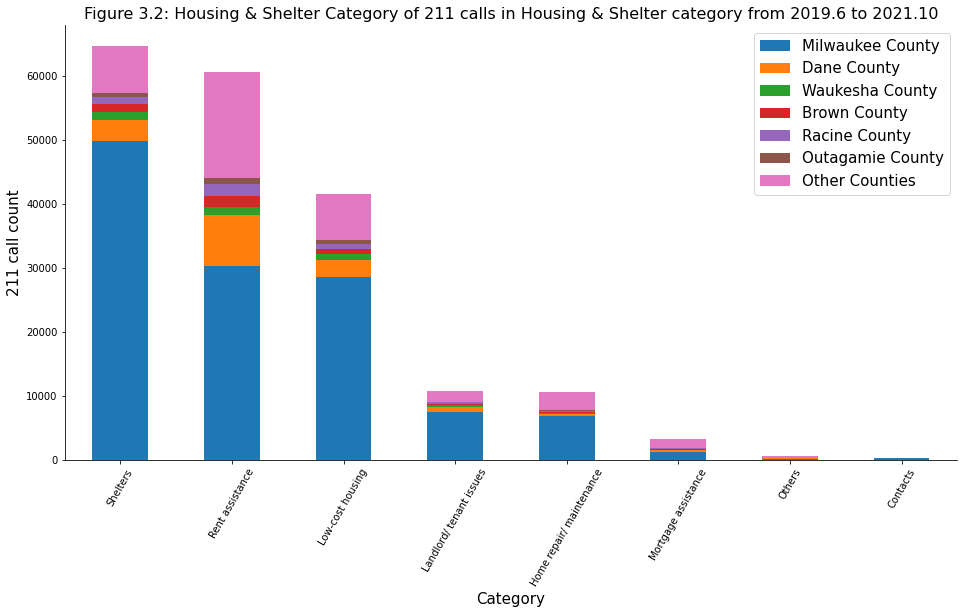

In [83]:
housing_calls = result_df[["COUNTY", "(Housing & Shelter) Shelters", "(Housing & Shelter) Low-cost housing", "(Housing & Shelter) Home repair/ maintenance",
           "(Housing & Shelter) Rent assistance", "(Housing & Shelter) Mortgage assistance", "(Housing & Shelter) Landlord/ tenant issues",
           "(Housing & Shelter) Contacts","(Housing & Shelter) Other housing & shelter"]]
housing_calls = housing_calls.rename(columns = {"(Housing & Shelter) Shelters":"Shelters",
                                "(Housing & Shelter) Low-cost housing": "Low-cost housing",
                                "(Housing & Shelter) Home repair/ maintenance": "Home repair/ maintenance",
                                "(Housing & Shelter) Rent assistance":"Rent assistance",
                                "(Housing & Shelter) Mortgage assistance": "Mortgage assistance",
                                "(Housing & Shelter) Landlord/ tenant issues": "Landlord/ tenant issues",
                                "(Housing & Shelter) Contacts": "Contacts",
                                "(Housing & Shelter) Other housing & shelter": "Others"})
housing_calls.set_index(["COUNTY"], inplace = True)
housing_calls = housing_calls.T
housing_calls["All"] = housing_calls.apply(lambda x:x.sum(),axis =1)
ax_housing = housing_calls.sort_values('All', ascending=False)[["Milwaukee County", "Dane County", "Waukesha County",
                  "Brown County", "Racine County", "Outagamie County", "Other Counties"]].plot(kind="bar", stacked=True, figsize=(16,8))
ax_housing.set_title("Figure 3.2: Housing & Shelter Category of 211 calls in Housing & Shelter category from 2019.6 to 2021.10", fontsize=16)
ax_housing.spines["top"].set_visible(False)
ax_housing.spines["right"].set_visible(False)
for tick in ax_housing.get_xticklabels():
    tick.set_rotation(60)
ax_housing.set_ylabel("211 call count", fontsize= 15)
ax_housing.set_xlabel("Category", fontsize= 15)
ax_housing.legend(fontsize=15, loc='upper right')

## Forcasting (Current month data)
### Using Lasso to reduce the number of column

In [43]:
# Combine case data and 211 calls data
# Because we do not have case data after June 2021, so drop 211 calls data after June 2021
calls_and_cases = call_counts.merge(case_data, on=["COUNTY","DATE"])
calls_and_cases = calls_and_cases.dropna()
calls_and_cases.to_csv("calls_and_cases.csv", index = False)
calls_and_cases

,COUNTY,DATE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,...,(Other) Community development & enrichment,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests,Filled,Judgement,Population
0,Dodge County,Aug 2019,21,6,6,4,6,1,2,0,...,0,0,0,0,0,0,0,23,12,87715
1,Columbia County,Nov 2019,2,5,2,5,3,0,0,0,...,0,0,1,0,0,0,3,14,1,57133
2,Bayfield County,Jun 2020,1,0,1,4,6,0,0,0,...,0,0,0,0,0,0,0,2,2,14993
3,Buffalo County,Mar 2021,7,0,1,12,3,1,0,0,...,0,0,0,0,0,0,0,0,1,13126
4,Waupaca County,Apr 2021,15,2,1,42,6,2,3,0,...,0,1,0,0,1,0,1,6,0,51245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,Walworth County,Mar 2021,26,0,8,191,18,4,1,0,...,0,1,0,0,1,0,1,16,2,103074
2012,Bayfield County,Jan 2021,1,0,0,1,3,0,0,0,...,0,0,0,0,0,0,1,0,0,14993
2013,Adams County,Sep 2019,13,5,11,4,6,0,2,0,...,0,1,0,2,0,0,2,6,1,20094
2014,Winnebago County,Mar 2020,94,51,23,94,17,30,11,7,...,1,7,1,2,2,0,10,40,8,170411


### Forcasting in month level (May be this is more suitable for predicting total fills in the whole Wisconsin in a month, but the dataset may be too small) (Disregard)

In [44]:
tmp = pd.read_csv("calls_and_cases.csv")
calls_and_cases_month = tmp.groupby("DATE", as_index=False).sum()

# filter outlier
outlier = calls_and_cases_month[(calls_and_cases_month.DATE == 'Jul 2019')].index
calls_and_cases_month = calls_and_cases_month.drop(outlier)


# select columns
column_list = list(calls_and_cases.columns)
all_sub = [n for n in column_list if '(' in n ]
training_col = [["Population"],
                ["Total for top requests"],
                ["Population", "Total for top requests"],
                ["Housing & Shelter", "Food", "Utilities", "Healthcare & COVID-19",
                 "Mental Health & Addictions", "Employment & Income", "Clothing & Household",
                 "Child Care & Parenting", "Government & Legal", "Transportation Assistance", "Education", "Disaster", "Other"],
                ["Housing & Shelter", "Food", "Utilities", "Healthcare & COVID-19",
                 "Mental Health & Addictions", "Employment & Income", "Clothing & Household",
                 "Child Care & Parenting", "Government & Legal", "Transportation Assistance", "Education", "Disaster", "Other", "Population"],
                all_sub,
                all_sub + ["Population"],
                ["Housing & Shelter"],
                ["Housing & Shelter", "Population"],
                ["(Housing & Shelter) Shelters", "(Housing & Shelter) Low-cost housing",
                 "(Housing & Shelter) Home repair/ maintenance", "(Housing & Shelter) Rent assistance",
                 "(Housing & Shelter) Mortgage assistance", "(Housing & Shelter) Landlord/ tenant issues",
                 "(Housing & Shelter) Contacts", "(Housing & Shelter) Other housing & shelter"],
                ["(Housing & Shelter) Shelters", "(Housing & Shelter) Low-cost housing",
                 "(Housing & Shelter) Home repair/ maintenance", "(Housing & Shelter) Rent assistance",
                 "(Housing & Shelter) Mortgage assistance", "(Housing & Shelter) Landlord/ tenant issues",
                 "(Housing & Shelter) Contacts", "(Housing & Shelter) Other housing & shelter", "Population"]
                ]
selected_col_name = ["Population",
                     "Total 211 Calls",
                     "Total 211 Calls and Population",
                     "All big categories",
                     "All big categories and population",
                     "All sub categories",
                     "All sub categories and population",
                     "Only Housing & Shelter Category",
                     "Housing and population",
                     "Sub categories in Housing & Shelter",
                     "Both Sub housing and Population"]


# import Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models=[LinearRegression(),KNeighborsRegressor(),SVR(),Ridge(),Lasso(),MLPRegressor(alpha=20),DecisionTreeRegressor(), RandomForestRegressor(),GradientBoostingRegressor()]
models_str=['LinearRegression','KNNRegressor','SVR','Ridge','Lasso','MLPRegressor','DecisionTree','RandomForest','GradientBoost']


In [45]:
# # training all models
# # for x_col in training_col:
# forcast_result = pd.DataFrame()
# index = 0
# for x_col, col_name in zip(training_col, selected_col_name):
#     x = calls_and_cases_month[x_col]
#     y = calls_and_cases_month["Filled"]
#     x_dum=pd.get_dummies(x)
#     x_train,x_test,y_train,y_test = train_test_split(x_dum,y,test_size = 0.2,random_state = 1)
#     for name,model in zip(models_str,models):
#         cur_model = model
#         cur_model.fit(x_train, y_train)
#         y_pred = cur_model.predict(x_test)
#         score = cur_model.score(x_test, y_test)
#         # cv = KFold(n_splits=10, random_state=1, shuffle=True)
#         # cv_scores = cross_val_score(cur_model, x_train, y_train, scoring= 'neg_mean_absolute_error', cv = cv, n_jobs=1)
#         # cv_score = mean(absolute(cv_scores))
#         current_dict = {"Selected Columns":col_name, "Model Name": name, "Score": score}
#         current_frame = pd.DataFrame(current_dict, index = [index])
#         index += 1
#         frames = [forcast_result, current_frame]
#         forcast_result = pd.concat(frames)
#
# forcast_result



## It looks like using MLPRegressor has the highest performance, using all sub categories

### Not format the data, just using the the 211 calls and fills for each county and each month (Maybe this model is better for predicting the eviction number for one county in a month) (Disregard)

In [46]:
# lasso_dataset = calls_and_cases.copy()
# columns_ratio = calls_and_cases.columns.tolist()
# columns_ratio.remove('COUNTY')
# columns_ratio.remove('DATE')
# columns_ratio.remove('Population')
# # predict per captia
# for element in columns_ratio:
#     lasso_dataset[element] = lasso_dataset[element] /lasso_dataset["Population"]
#
# forcast_result_raw = pd.DataFrame()
# index = 0
# for x_col, col_name in zip(training_col, selected_col_name):
#     x = lasso_dataset[x_col]
#     y = lasso_dataset["Filled"]
#     x_dum=pd.get_dummies(x)
#     x_train,x_test,y_train,y_test = train_test_split(x_dum,y,test_size = 0.3,random_state = 1)
#     for name,model in zip(models_str,models):
#         cur_model = model
#         cur_model.fit(x_train, y_train)
#         y_pred = cur_model.predict(x_test)
#         score = cur_model.score(x_test, y_test)
#         cv = KFold(n_splits=10, random_state=1, shuffle=True)
#         cv_scores = cross_val_score(cur_model, x_train, y_train, scoring='r2', cv = cv, n_jobs=1)
#         cv_score = mean(absolute(cv_scores))
#         current_dict = {"Selected Columns":col_name, "Model Name": name, "Score": score, "CV Score": cv_score}
#         current_frame = pd.DataFrame(current_dict, index = [index])
#         index += 1
#         frames = [forcast_result_raw, current_frame]
#         forcast_result_raw = pd.concat(frames)
#
# forcast_result_raw

## It looks like using KNNRegressor has the highest performance, using all sub categories

### Forcasting Result plot (Disregard)

In [47]:
# positive_result = forcast_result[forcast_result["Score"] >= 0]
# Columns = list(positive_result["Selected Columns"].drop_duplicates())
# Model = list(positive_result["Model Name"].drop_duplicates())
# filter1 = forcast_result["Model Name"].isin(Model)
# tmp = forcast_result[filter1]
# filter2 = forcast_result["Selected Columns"].isin(Columns)
# plot_filter = tmp[filter2]
# plot_filter.loc[~(plot_filter['Score'] > 0), 'Score'] = -0.01
# selected_column = dict()
# selected_column["211 Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls"]["Score"])
# selected_column["211 + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls and Population"]["Score"])
# selected_column["211 Big Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories"]["Score"])
# selected_column["211 Big Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories and population"]["Score"])
# selected_column["211 Sub category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories"]["Score"])
# selected_column["211 Sub category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories and population"]["Score"])
# selected_column["211 Housing & Shelter Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Only Housing & Shelter Category"]["Score"])
# selected_column["211 Housing & Shelter + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Housing and population"]["Score"])
# selected_column["211 Sub Housing Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Sub categories in Housing & Shelter"]["Score"])
# selected_column["211 Sub Housing Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Both Sub housing and Population"]["Score"])
# patterns = ('/','//','-', '+', 'x', '\\', '\\\\', '*', 'o', 'O', '.')
#
# x=np.arange(8)
# bar_width = 1/12
# tick_label = list(plot_filter["Model Name"].drop_duplicates())
# times = 0
# color=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tan', 'grey', 'skyblue', 'pink']
# plt.figure(figsize=(16,8))
# for key, value in selected_column.items():
#     plt.bar(x + bar_width*times,value,bar_width,color=color[times],label=key)
#     times += 1
#
#
# plt.legend(loc="upper left", fontsize = 10)
# plt.xticks(x+bar_width*3,tick_label)
# plt.title("Figure: R Square for different Model in Month Level")
# plt.ylabel("R Square Score")
# plt.xlabel("Different Forcasting Model")
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

In [48]:
# positive_result = forcast_result_raw[forcast_result_raw["Score"] >= 0]
# Columns = list(positive_result["Selected Columns"].drop_duplicates())
# Model = list(positive_result["Model Name"].drop_duplicates())
# filter1 = forcast_result_raw["Model Name"].isin(Model)
# tmp = forcast_result_raw[filter1]
# filter2 = forcast_result_raw["Selected Columns"].isin(Columns)
# plot_filter = tmp[filter2]
# plot_filter.loc[~(plot_filter['Score'] > 0), 'Score'] = -0.01
# selected_column = dict()
# selected_column["Population Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Population"]["Score"])
# selected_column["211 Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls"]["Score"])
# selected_column["211 + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls and Population"]["Score"])
# selected_column["211 Big Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories"]["Score"])
# selected_column["211 Big Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories and population"]["Score"])
# selected_column["211 Sub category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories"]["Score"])
# selected_column["211 Sub category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories and population"]["Score"])
# selected_column["211 Housing & Shelter Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Only Housing & Shelter Category"]["Score"])
# selected_column["211 Housing & Shelter + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Housing and population"]["Score"])
# selected_column["211 Sub Housing Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Sub categories in Housing & Shelter"]["Score"])
# selected_column["211 Sub Housing Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Both Sub housing and Population"]["Score"])
#
#
# x=np.arange(9)
# bar_width = 1/13
# tick_label = list(plot_filter["Model Name"].drop_duplicates())
# times = 0
# color=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tan', 'grey', 'skyblue', 'pink']
# plt.figure(figsize=(24,12))
# for key, value in selected_column.items():
#     plt.bar(x + bar_width*times,value,bar_width,color=color[times],label=key)
#     times += 1
#
#
# plt.legend(loc="upper left", fontsize = 10)
# plt.xticks(x+bar_width*3,tick_label)
# plt.title("Figure: R Square for different Model in Month Level")
# plt.ylabel("R Square Score")
# plt.xlabel("Different Forcasting Model")
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)


### Judgement per capita in Wisconsin

In [49]:
import matplotlib.patches as mpatches
import mapclassify as mc

tmp = pd.read_csv("calls_and_cases.csv")
filled_Judgment_Population = tmp.groupby("COUNTY", as_index=False).sum()[["COUNTY", "Filled", "Judgement"]].merge(tmp[["COUNTY", "Population"]].drop_duplicates())
filled_Judgment_Population["Filled_per_capita"] = filled_Judgment_Population["Filled"]/filled_Judgment_Population["Population"]
filled_Judgment_Population["Judgement_per_capita"] = filled_Judgment_Population["Judgement"]/filled_Judgment_Population["Population"]

filled_Judgment_Population

,COUNTY,Filled,Judgement,Population,Filled_per_capita,Judgement_per_capita
0,Adams County,70,18,20094,0.003484,0.000896
1,Ashland County,44,14,15617,0.002817,0.000896
2,Barron County,195,66,45229,0.004311,0.001459
3,Bayfield County,19,7,14993,0.001267,0.000467
4,Brown County,1848,275,261368,0.007070,0.001052
...,...,...,...,...,...,...
67,Waukesha County,716,98,400475,0.001788,0.000245
68,Waupaca County,150,11,51245,0.002927,0.000215
69,Waushara County,51,29,24193,0.002108,0.001199
70,Winnebago County,1322,231,170411,0.007758,0.001356


Text(0.5, 1.0, 'Figure: Filled Per Capita in Wisconsin per county')

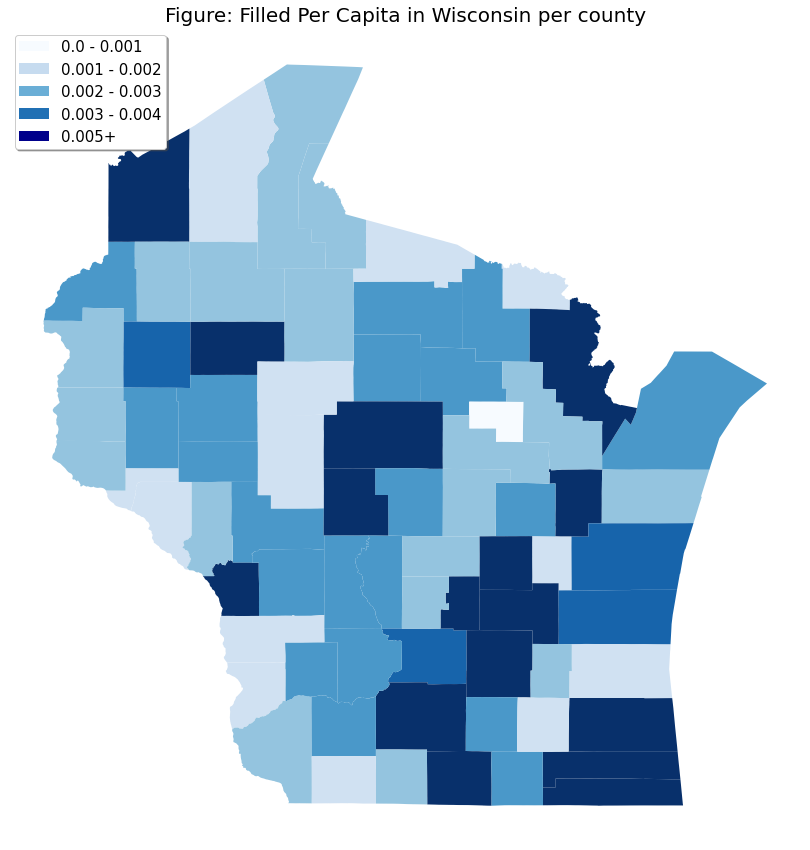

In [50]:
wisconsin = gpd.read_file("Wisconsin/counties.geojson")
wisconsin = wisconsin[["NAME", "geometry"]]

filled_Judgment_Population = filled_Judgment_Population.rename(columns = {"COUNTY": "NAME"})
merged_map = filled_Judgment_Population.merge(wisconsin, on = "NAME")
merged_map = gpd.GeoDataFrame(merged_map)

bp = mc.UserDefined(merged_map["Filled_per_capita"], bins=[0.001, 0.002, 0.003, 0.004, 0.005])
ax = merged_map.plot(figsize = (20, 15), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [0.001, 0.002, 0.003, 0.004, 0.005]},
                  k = 5, column='Filled_per_capita', cmap = 'Blues')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('Blues')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{max(bins[_], 0)} - {bins[_+1]}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='#00008b', hatch='', label='0.005+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=15, shadow=True, borderpad=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axis('off')
ax.set_title("Figure: Filled Per Capita in Wisconsin per county", fontsize = 20)

Text(0.5, 1.0, 'Figure: Judgment Per Capita in Wisconsin per county')

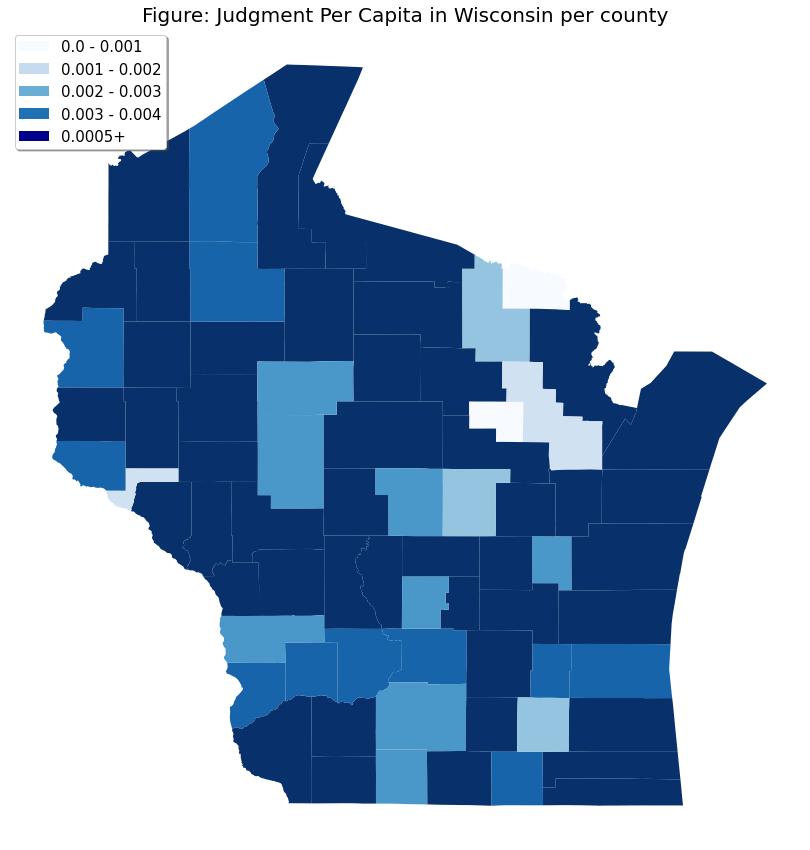

In [51]:
bp = mc.UserDefined(merged_map["Judgement_per_capita"], bins=[0.001, 0.002, 0.003, 0.004, 0.005])
ax = merged_map.plot(figsize = (20, 15), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]},
                  k = 5, column='Judgement_per_capita', cmap = 'Blues')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('Blues')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{max(bins[_], 0)} - {bins[_+1]}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='#00008b', hatch='', label='0.0005+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=15, shadow=True, borderpad=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axis('off')
ax.set_title("Figure: Judgment Per Capita in Wisconsin per county", fontsize = 20)

### Forcasting for using previous month's data to predict fills and judgments number in month level (Disregard)

In [52]:
tmp = pd.read_csv("calls_and_cases.csv")
calls_and_cases_month_next = tmp.groupby("DATE", as_index=False).sum()

# filter outlier
outlier = calls_and_cases_month_next[(calls_and_cases_month_next.DATE == 'Jul 2019')].index
calls_and_cases_month_next = calls_and_cases_month_next.drop(outlier)


calls_and_cases_month_next['DATE'] = pd.Categorical(calls_and_cases_month_next['DATE'], categories=months_by_year, ordered=True)
calls_and_cases_month_next.sort_values(by='DATE',ascending=True,inplace=True)
next_month = list(calls_and_cases_month_next["Filled"])[1:]
next_month.append(0)
calls_and_cases_month_next["Next Month Filled"] = next_month
calls_and_cases_month_next = calls_and_cases_month_next.drop(13)
calls_and_cases_month_next

,DATE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,Government & Legal,...,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests,Filled,Judgement,Population,Next Month Filled
2,Aug 2019,5786,3657,1595,1292,3094,554,1230,111,1220,...,203,118,56,208,0,695,2667,367,5790716,2388
22,Sep 2019,6054,3166,1605,1360,3411,498,1087,140,1154,...,213,119,61,195,0,591,2388,389,5790716,2589
20,Oct 2019,5563,3240,1494,1283,3136,603,1300,114,1103,...,232,94,54,170,0,641,2589,413,5790716,2116
18,Nov 2019,5188,3367,1020,1286,2979,449,1481,86,930,...,230,85,33,152,0,583,2116,326,5790716,2148
4,Dec 2019,4132,3415,547,1398,2713,436,1437,57,950,...,199,86,33,149,0,466,2148,308,5790716,2755
8,Jan 2020,4966,3092,539,1327,3227,1662,1170,112,1022,...,192,89,40,190,0,489,2755,327,5790716,2152
6,Feb 2020,5624,2749,492,1234,3894,2223,890,92,1150,...,144,87,39,200,0,530,2152,277,5790716,1084
14,Mar 2020,6393,3826,1056,3085,3717,1909,748,119,1281,...,172,83,33,159,0,780,1084,151,5790716,54
0,Apr 2020,5320,5976,1497,3405,3835,1568,771,62,1613,...,189,78,50,209,0,908,54,45,5790716,365
16,May 2020,3913,3808,1043,4696,3791,1434,585,45,1544,...,195,72,44,164,1,552,365,36,5790716,3042


In [53]:

# forcast_result_next_month = pd.DataFrame()
# index = 0
# for x_col, col_name in zip(training_col, selected_col_name):
#     x = calls_and_cases_month_next[x_col]
#     y = calls_and_cases_month_next["Next Month Filled"]
#     x_dum=pd.get_dummies(x)
#     x_train,x_test,y_train,y_test = train_test_split(x_dum,y,test_size = 0.2,random_state = 1)
#     for name,model in zip(models_str,models):
#         cur_model = model
#         cur_model.fit(x_train, y_train)
#         y_pred = cur_model.predict(x_test)
#         score = cur_model.score(x_test, y_test)
#         # cv = KFold(n_splits=10, random_state=1, shuffle=True)
#         # cv_scores = cross_val_score(cur_model, x_train, y_train, scoring='neg_mean_absolute_error', cv = cv, n_jobs=1)
#         # cv_score = mean(absolute(cv_scores))
#         current_dict = {"Selected Columns":col_name, "Model Name": name, "Score": score}
#         current_frame = pd.DataFrame(current_dict, index = [index])
#         index += 1
#         frames = [forcast_result_next_month, current_frame]
#         forcast_result_next_month = pd.concat(frames)
#
# forcast_result_next_month

In [54]:
# positive_result = forcast_result_next_month[forcast_result_next_month["Score"] >= 0]
# Columns = list(positive_result["Selected Columns"].drop_duplicates())
# Model = list(positive_result["Model Name"].drop_duplicates())
# filter1 = forcast_result_next_month["Model Name"].isin(Model)
# tmp = forcast_result_next_month[filter1]
# filter2 = forcast_result_next_month["Selected Columns"].isin(Columns)
# plot_filter = tmp[filter2]
# plot_filter.loc[~(plot_filter['Score'] > 0), 'Score'] = -0.01
# selected_column = dict()
# selected_column["211 Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls"]["Score"])
# selected_column["211 + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Total 211 Calls and Population"]["Score"])
# selected_column["211 Big Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories"]["Score"])
# selected_column["211 Big Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All big categories and population"]["Score"])
# selected_column["211 Sub category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories"]["Score"])
# selected_column["211 Sub category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "All sub categories and population"]["Score"])
# selected_column["211 Housing & Shelter Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Only Housing & Shelter Category"]["Score"])
# selected_column["211 Housing & Shelter + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Housing and population"]["Score"])
# selected_column["211 Sub Housing Category Only"] = list(plot_filter[plot_filter["Selected Columns"] == "Sub categories in Housing & Shelter"]["Score"])
# selected_column["211 Sub Housing Category + Population"] = list(plot_filter[plot_filter["Selected Columns"] == "Both Sub housing and Population"]["Score"])
#
#
# x=np.arange(8)
# bar_width = 1/12
# tick_label = list(plot_filter["Model Name"].drop_duplicates())
# times = 0
# color=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tan', 'grey', 'skyblue', 'pink']
# plt.figure(figsize=(24,12))
# for key, value in selected_column.items():
#     plt.bar(x + bar_width*times,value,bar_width,color=color[times],label=key)
#     times += 1
#
#
# plt.legend(loc="upper left", fontsize = 10)
# plt.xticks(x+bar_width*4,tick_label)
# plt.title("Figure: R Square for different Model in Month Level")
# plt.ylabel("R Square Score")
# plt.xlabel("Different Forcasting Model")
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

In [55]:
calls_and_cases = pd.read_csv("calls_and_cases.csv")
counties = list(calls_and_cases["COUNTY"].drop_duplicates())
calls_and_cases_month_next_raw = pd.DataFrame()
for county in counties:
    current = calls_and_cases[calls_and_cases["COUNTY"] == county]
    # outlier = current[(current.DATE == 'Jul 2019')].index
    # current = current.drop(outlier)
    current['DATE'] = pd.Categorical(current['DATE'], categories=months_by_year, ordered=True)
    current.sort_values(by='DATE',ascending=True,inplace=True)
    next_month = list(current["Filled"])[1:]
    next_month.append(0)
    current["Next Month Filled"] = next_month
    last_month = current[(current.DATE == 'Jun 2021')].index
    current = current.drop(last_month)
    frames = [calls_and_cases_month_next_raw, current]
    calls_and_cases_month_next_raw = pd.concat(frames)
calls_and_cases_month_next_raw

<ipython-input-55-18d12538d3eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current['DATE'] = pd.Categorical(current['DATE'], categories=months_by_year, ordered=True)
<ipython-input-55-18d12538d3eb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current.sort_values(by='DATE',ascending=True,inplace=True)
<ipython-input-55-18d12538d3eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,COUNTY,DATE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,...,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests,Filled,Judgement,Population,Next Month Filled
1420,Dodge County,Jul 2019,31,2,9,5,10,2,0,1,...,1,0,0,0,0,1,28,5,87715,23
0,Dodge County,Aug 2019,21,6,6,4,6,1,2,0,...,0,0,0,0,0,0,23,12,87715,25
553,Dodge County,Sep 2019,8,1,7,0,11,3,2,0,...,0,0,0,0,0,1,25,8,87715,27
448,Dodge County,Oct 2019,7,6,2,2,5,1,2,1,...,0,0,0,1,0,4,27,13,87715,25
668,Dodge County,Nov 2019,16,2,3,4,6,2,1,0,...,1,0,1,0,0,1,25,6,87715,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,Adams County,Jan 2021,11,6,4,22,3,2,0,0,...,0,1,0,0,0,2,0,0,20094,0
441,Adams County,Feb 2021,26,1,8,24,9,6,3,0,...,0,0,1,0,0,3,0,1,20094,2
670,Adams County,Mar 2021,10,4,4,48,14,6,0,0,...,0,1,0,1,0,2,2,0,20094,3
761,Adams County,Apr 2021,3,2,4,38,10,0,2,0,...,1,0,0,0,0,0,3,0,20094,2


#### Change amount of filled to per captia (failed)

In [56]:
lasso_dataset = calls_and_cases_month_next_raw.copy()
# columns_ratio = calls_and_cases_month_next_raw.columns.tolist()
# columns_ratio.remove('COUNTY')
# columns_ratio.remove('DATE')
# columns_ratio.remove('Population')
# #predict per captia
# for element in columns_ratio:
#     lasso_dataset[element] = lasso_dataset[element] /lasso_dataset["Population"]
    # lasso_dataset[element]=(lasso_dataset[element]-lasso_dataset[element].mean())/lasso_dataset[element].std()

# lasso_dataset["Next Month Filled"] = lasso_dataset["Next Month Filled"]/lasso_dataset["Population"]
# lasso_dataset = lasso_dataset.drop(["(Child Care & Parenting) Other child care"], axis=1)
# lasso_dataset = lasso_dataset.drop(["(Child Care & Parenting) Other child care & parenting", "(Clothing & Household) Contacts", "(Transportation Assistance) Contacts"], axis = 1)
# lasso_dataset = lasso_dataset.dropna()
# lasso_dataset["Next Month Filled"] = lasso_dataset["Next Month Filled"] / lasso_dataset["Population"]
lasso_dataset


,COUNTY,DATE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,...,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests,Filled,Judgement,Population,Next Month Filled
1420,Dodge County,Jul 2019,31,2,9,5,10,2,0,1,...,1,0,0,0,0,1,28,5,87715,23
0,Dodge County,Aug 2019,21,6,6,4,6,1,2,0,...,0,0,0,0,0,0,23,12,87715,25
553,Dodge County,Sep 2019,8,1,7,0,11,3,2,0,...,0,0,0,0,0,1,25,8,87715,27
448,Dodge County,Oct 2019,7,6,2,2,5,1,2,1,...,0,0,0,1,0,4,27,13,87715,25
668,Dodge County,Nov 2019,16,2,3,4,6,2,1,0,...,1,0,1,0,0,1,25,6,87715,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,Adams County,Jan 2021,11,6,4,22,3,2,0,0,...,0,1,0,0,0,2,0,0,20094,0
441,Adams County,Feb 2021,26,1,8,24,9,6,3,0,...,0,0,1,0,0,3,0,1,20094,2
670,Adams County,Mar 2021,10,4,4,48,14,6,0,0,...,0,1,0,1,0,2,2,0,20094,3
761,Adams County,Apr 2021,3,2,4,38,10,0,2,0,...,1,0,0,0,0,0,3,0,20094,2


### Using Lasso to reduce variables

#### not sure doing lasso for all variables just one times, or doing lasso for each combination

In [144]:
lasso_trail_x_col = training_col[10]
lasso_trail_y_col = ["Next Month Filled"]

x = lasso_dataset[lasso_trail_x_col]
y = lasso_dataset[lasso_trail_y_col]

from sklearn.linear_model import Lasso
def lasso_regression(x_train, y_train, x_test, y_test, alpha):
    lasso_reg = Pipeline([
            ("std", StandardScaler()),
            ("lasso", Lasso(alpha=alpha))
        ])
    lasso_reg.fit(x_train,y_train)
    y_pred = lasso_reg.predict(x_test)
    result = [alpha, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
    result.extend(lasso_reg["lasso"].coef_)
    return result

alpha_lasso = np.arange(0,31,1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
result_col = ['Penalty','R2_score','MAE'] + lasso_trail_x_col
result_ind = [i for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=result_ind, columns=result_col)
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i] = lasso_regression(x_train,y_train,x_test,y_test, alpha_lasso[i])

coef_matrix_lasso

/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.427e+06, tolerance: 1.405e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

,Penalty,R2_score,MAE,(Housing & Shelter) Shelters,(Housing & Shelter) Low-cost housing,(Housing & Shelter) Home repair/ maintenance,(Housing & Shelter) Rent assistance,(Housing & Shelter) Mortgage assistance,(Housing & Shelter) Landlord/ tenant issues,(Housing & Shelter) Contacts,(Housing & Shelter) Other housing & shelter,Population
0,0,0.757072,16.341457,-20.899912,2.812217,13.905561,-33.627867,-53.003769,129.667962,3.742852,6.072542,35.083943
1,1,0.71561,15.65726,7.005759,-0.0,14.111201,-0.0,-49.151364,80.655851,0.003419,0.661992,30.930042
2,2,0.710188,14.883407,12.26085,0.0,10.240733,-0.0,-39.719824,72.376109,0.0,0.0,28.939748
3,3,0.70041,14.266817,17.676772,0.0,6.623657,-0.0,-30.607859,63.810276,0.0,0.0,26.70361
4,4,0.688237,13.75461,23.096781,0.0,3.008687,0.0,-21.493635,55.237094,0.0,0.0,24.467097
5,5,0.672935,13.545894,28.585915,0.0,0.0,0.0,-12.496613,46.090648,0.0,0.0,22.287191
6,6,0.651301,13.830299,34.400177,0.0,0.0,0.0,-4.080952,34.11115,0.0,0.0,20.39237
7,7,0.638476,14.086,36.999213,0.0,0.0,0.0,-0.0,28.216101,0.0,0.0,19.201065
8,8,0.635823,14.195041,36.549039,0.0,0.0,0.0,-0.0,28.069466,0.0,0.0,18.67296
9,9,0.632998,14.315483,36.099218,0.0,0.0,0.0,-0.0,27.922523,0.0,0.0,18.14483


Text(0, 0.5, 'Coefficient')

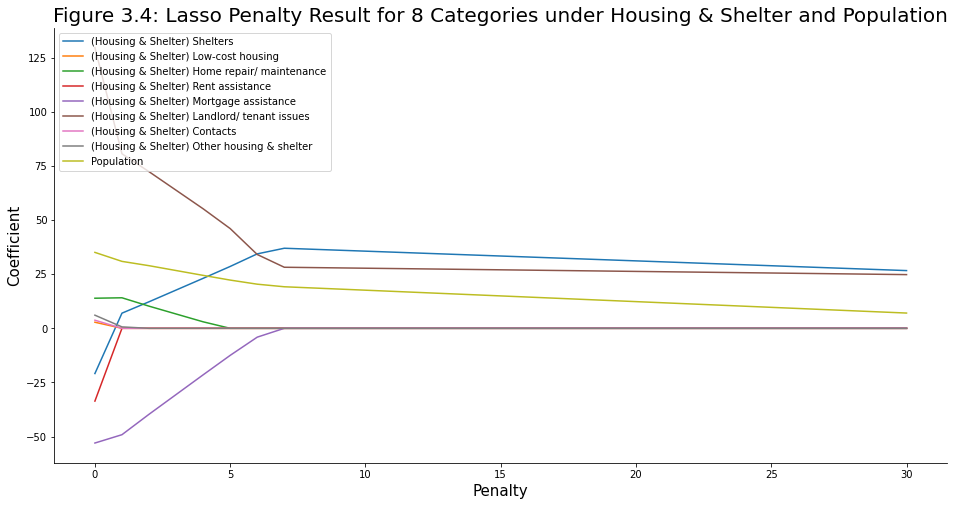

In [145]:
lasso_penalty_plot = coef_matrix_lasso.plot.line(x="Penalty", y= ["(Housing & Shelter) Shelters", "(Housing & Shelter) Low-cost housing",
                 "(Housing & Shelter) Home repair/ maintenance", "(Housing & Shelter) Rent assistance",
                 "(Housing & Shelter) Mortgage assistance", "(Housing & Shelter) Landlord/ tenant issues",
                 "(Housing & Shelter) Contacts", "(Housing & Shelter) Other housing & shelter", "Population"], figsize = (16, 8))
lasso_penalty_plot.set_title("Figure 3.4: Lasso Penalty Result for 8 Categories under Housing & Shelter and Population", fontsize = 20)
lasso_penalty_plot.spines["top"].set_visible(False)
lasso_penalty_plot.spines["right"].set_visible(False)
lasso_penalty_plot.legend(fontsize=10, loc='upper left')
lasso_penalty_plot.set_xlabel("Penalty", fontsize=15)
lasso_penalty_plot.set_ylabel("Coefficient", fontsize=15)

In [146]:
lasso_trail_x_col = training_col[4]
lasso_trail_y_col = ["Next Month Filled"]

x = lasso_dataset[lasso_trail_x_col]
y = lasso_dataset[lasso_trail_y_col]

from sklearn.linear_model import Lasso
def lasso_regression(x_train, y_train, x_test, y_test, alpha):
    lasso_reg = Pipeline([
            ("std", StandardScaler()),
            ("lasso", Lasso(alpha=alpha))
        ])
    lasso_reg.fit(x_train,y_train)
    y_pred = lasso_reg.predict(x_test)
    result = [alpha, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
    result.extend(lasso_reg["lasso"].coef_)
    return result

alpha_lasso = np.arange(0,31,1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
result_col = ['Penalty','R2_score','MAE'] + lasso_trail_x_col
result_ind = [i for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=result_ind, columns=result_col)
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i] = lasso_regression(x_train,y_train,x_test,y_test, alpha_lasso[i])

coef_matrix_lasso

/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.944e+05, tolerance: 1.405e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

,Penalty,R2_score,MAE,Housing & Shelter,Food,Utilities,Healthcare & COVID-19,Mental Health & Addictions,Employment & Income,Clothing & Household,Child Care & Parenting,Government & Legal,Transportation Assistance,Education,Disaster,Other,Population
0,0,0.72789,16.787223,-84.101536,-18.514028,15.783952,-1.003727,20.703649,2.500994,134.44159,-3.17495,84.908159,-25.273355,16.048161,18.995595,-79.226205,23.094181
1,1,0.654221,15.344651,-20.882649,-14.543517,6.831972,-0.0,5.524312,-0.66123,101.987799,-0.0,0.0,-21.581108,13.072228,14.314883,-8.934041,24.234578
2,2,0.669908,15.158863,-0.0,-3.118718,1.006995,-0.0,0.0,-2.629996,80.563111,-0.0,0.0,-13.493868,10.311381,7.491744,-0.0,15.582417
3,3,0.68129,14.960092,-0.0,-0.0,0.269051,-0.0,0.0,-0.763491,78.902196,0.0,0.0,-8.018503,8.421631,5.851891,-0.0,10.271159
4,4,0.674175,15.265925,0.0,-0.0,0.0,0.0,1.198599,-0.0,78.853883,0.0,0.0,-1.810745,6.575072,4.100652,0.0,4.99117
5,5,0.671902,15.525773,0.0,0.0,0.0,0.0,2.064476,-0.0,78.348582,0.0,0.0,-0.0,5.587016,3.057885,0.0,3.343667
6,6,0.672382,15.598101,0.0,0.0,0.0,0.0,2.100097,-0.0,78.053288,0.0,0.0,-0.0,4.95096,2.372036,0.0,3.28654
7,7,0.67267,15.676983,0.0,0.0,0.0,0.0,2.135946,-0.0,77.759566,0.0,0.0,-0.0,4.315508,1.686984,0.0,3.227173
8,8,0.672769,15.762036,0.0,0.0,0.0,0.0,2.172573,-0.0,77.466179,0.0,0.0,-0.0,3.680311,1.00213,0.0,3.166638
9,9,0.67267,15.857579,0.0,0.0,0.0,0.0,2.208211,0.0,77.176748,0.0,0.0,0.0,3.04636,0.319222,0.0,3.101961


Text(0, 0.5, 'Coefficient')

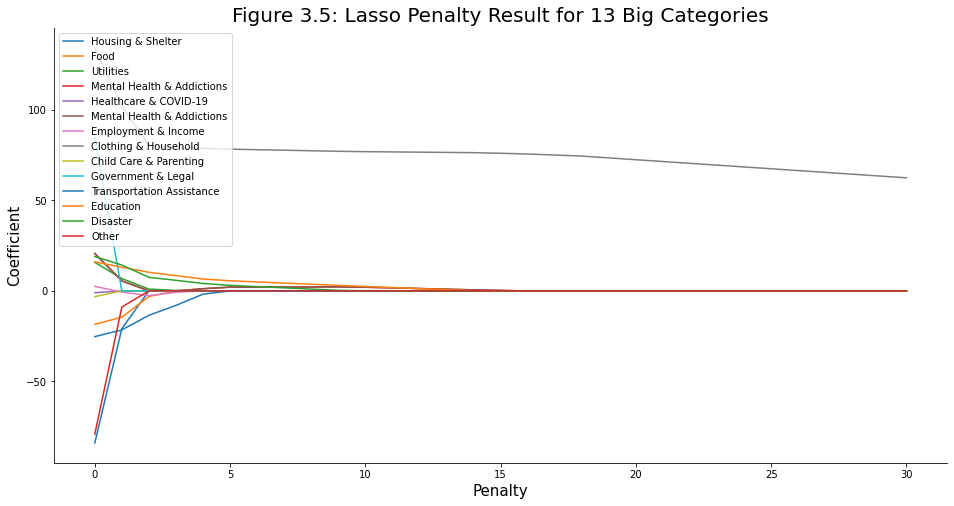

In [147]:
lasso_penalty_plot = coef_matrix_lasso.plot.line(x="Penalty", y= ["Housing & Shelter", "Food", "Utilities",
                                                                  "Mental Health & Addictions", "Healthcare & COVID-19",
                                                                  "Mental Health & Addictions", "Employment & Income",
                                                                  "Clothing & Household", "Child Care & Parenting",
                                                                  "Government & Legal", "Transportation Assistance",
                                                                  "Education", "Disaster", "Other"], figsize = (16, 8))
lasso_penalty_plot.set_title("Figure 3.5: Lasso Penalty Result for 13 Big Categories", fontsize = 20)
lasso_penalty_plot.spines["top"].set_visible(False)
lasso_penalty_plot.spines["right"].set_visible(False)
lasso_penalty_plot.legend(fontsize=10, loc='upper left')
lasso_penalty_plot.set_xlabel("Penalty", fontsize=15)
lasso_penalty_plot.set_ylabel("Coefficient", fontsize=15)

#### If using all categories, things become strange

In [148]:
lasso_trail_x_col = training_col[6]
lasso_trail_y_col = ["Next Month Filled"]

x = lasso_dataset[lasso_trail_x_col]
y = lasso_dataset[lasso_trail_y_col]

from sklearn.linear_model import Lasso
def lasso_regression(x_train, y_train, x_test, y_test, alpha):
    lasso_reg = Pipeline([
            ("std", StandardScaler()),
            ("lasso", Lasso(alpha=alpha))
        ])
    lasso_reg.fit(x_train,y_train)
    y_pred = lasso_reg.predict(x_test)
    result = [alpha, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
    result.extend(lasso_reg["lasso"].coef_)
    return result

alpha_lasso = np.arange(0,31,1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
result_col = ['Penalty','R2_score','MAE'] + lasso_trail_x_col
result_ind = [i for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=result_ind, columns=result_col)
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i] = lasso_regression(x_train,y_train,x_test,y_test, alpha_lasso[i])

coef_matrix_lasso.iloc[30]

/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+05, tolerance: 1.405e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Penalty                                        30
R2_score                                 0.618357
MAE                                     18.972198
(Housing & Shelter) Shelters                  0.0
(Housing & Shelter) Low-cost housing          0.0
                                          ...    
(Other) Complaints                            0.0
(Other) Special population services           0.0
(Other) Special populations                   0.0
(Other) All other requests                    0.0
Population                                    0.0
Name: 30, Length: 108, dtype: object

Text(0, 0.5, 'Coefficient')

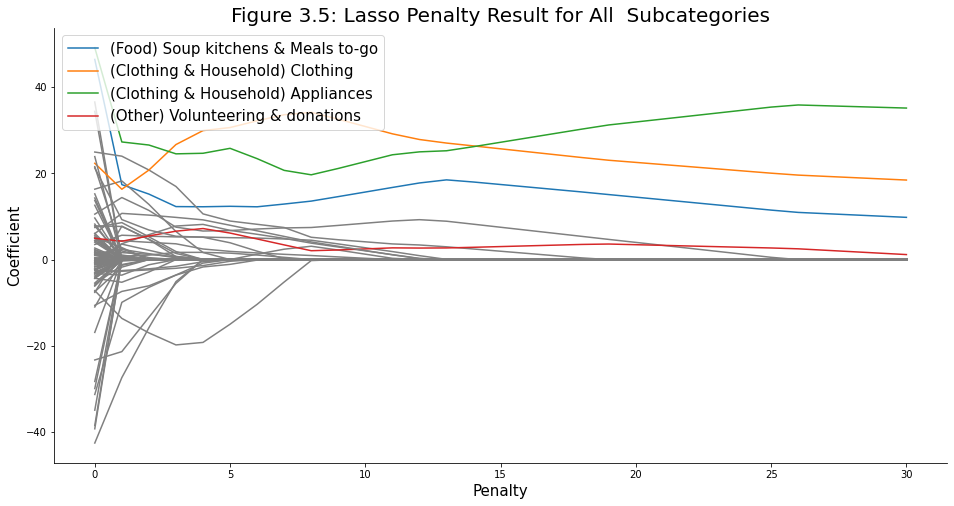

In [149]:
# lasso_penalty_plot = coef_matrix_lasso.plot.line(x="Penalty", y= "(Housing & Shelter) Shelters", figsize = (16, 8), legend=False)
# lasso_penalty_plot = coef_matrix_lasso.plot.line(x="Penalty", y= "(Housing & Shelter) Low-cost housing", figsize = (16, 8), legend=False)
# lasso_penalty_plot.set_title("Figure 3.5: Lasso Penalty Result for All Subcategories", fontsize = 20)
# lasso_penalty_plot.spines["top"].set_visible(False)
# lasso_penalty_plot.spines["right"].set_visible(False)
# plt.plot(coef_matrix_lasso["Penalty"], coef_matrix_lasso["(Housing & Shelter) Shelters"])
# plt.plot(coef_matrix_lasso["Penalty"], coef_matrix_lasso["(Housing & Shelter) Low-cost housing"])
non_zero_column = ["(Food) Soup kitchens & Meals to-go",
                           "(Clothing & Household) Clothing",
                           "(Clothing & Household) Appliances",
                           "(Other) Volunteering & donations"]
fig, ax = plt.subplots(figsize=(16, 8))
for column_name in training_col[6]:
    if column_name not in non_zero_column:
        line = ax.plot(coef_matrix_lasso["Penalty"], coef_matrix_lasso[column_name], color="grey")
    else:
        line = ax.plot(coef_matrix_lasso["Penalty"], coef_matrix_lasso[column_name], label = column_name)
ax.set_title("Figure 3.5: Lasso Penalty Result for All  Subcategories", fontsize = 20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=15, loc='upper left')
ax.set_xlabel("Penalty", fontsize=15)
ax.set_ylabel("Coefficient", fontsize=15)


In [62]:
lasso_trail_x_col = training_col[6]
lasso_trail_y_col = ["Next Month Filled"]

x = lasso_dataset[lasso_trail_x_col]
y = lasso_dataset[lasso_trail_y_col]

from sklearn.linear_model import Lasso
def lasso_regression(x_train, y_train, x_test, y_test, alpha):
    lasso_reg = Pipeline([
            ("std", StandardScaler()),
            ("lasso", Lasso(alpha=alpha))
        ])
    lasso_reg.fit(x_train,y_train)
    y_pred = lasso_reg.predict(x_test)
    result = [alpha, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
    result.extend(lasso_reg["lasso"].coef_)
    return result

alpha_lasso = np.arange(0,20,1)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
result_col = ['Penalty','R2_score','MAE'] + lasso_trail_x_col
result_ind = [i for i in range(0,len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=result_ind, columns=result_col)
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i] = lasso_regression(x_train,y_train,x_test,y_test, alpha_lasso[i])

coef_matrix_lasso

/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/wes/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+05, tolerance: 1.405e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

,Penalty,R2_score,MAE,(Housing & Shelter) Shelters,(Housing & Shelter) Low-cost housing,(Housing & Shelter) Home repair/ maintenance,(Housing & Shelter) Rent assistance,(Housing & Shelter) Mortgage assistance,(Housing & Shelter) Landlord/ tenant issues,(Housing & Shelter) Contacts,...,(Disaster) Other disaster,(Other) Agency & other contact information,(Other) Community development & enrichment,(Other) Volunteering & donations,(Other) Support & advocacy,(Other) Complaints,(Other) Special population services,(Other) Special populations,(Other) All other requests,Population
0,0,0.635733,18.075636,-38.480306,1.258619,8.238703,-0.302647,-7.441253,36.54217,-4.335241,...,-0.907745,-34.932451,4.909994,4.93983,-0.758422,9.64078,23.88646,6.027399,-29.911784,21.243417
1,1,0.59233,16.865941,0.0,-0.0,0.0,0.0,-1.751611,0.0,0.0,...,-0.0,0.0,-0.0,4.261184,0.0,-0.0,0.0,10.720168,-0.0,9.280819
2,2,0.621584,16.733287,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,5.486142,0.0,-0.0,0.0,10.318901,-0.0,6.859721
3,3,0.646886,17.286387,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,6.589288,0.0,-0.0,0.0,9.789476,-0.0,5.412394
4,4,0.659221,17.636859,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,7.201689,0.0,-0.0,0.0,9.214362,0.0,5.18678
5,5,0.666598,17.23226,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,6.15242,0.0,-0.0,0.0,7.964548,0.0,3.902259
6,6,0.673823,16.748767,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,4.783644,0.0,-0.0,0.0,6.668145,0.0,1.951015
7,7,0.676541,16.341034,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,3.404196,0.0,0.0,0.0,5.374488,0.0,0.219336
8,8,0.679895,16.003636,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,2.058033,0.0,0.0,0.0,4.091653,0.0,0.0
9,9,0.680571,16.12459,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,2.232236,0.0,0.0,0.0,3.090993,0.0,0.0


#### Using selected variables for prediction

In [151]:
after_lasso_result = pd.DataFrame()
index = 0
selected_col = [["(Housing & Shelter) Shelters","(Housing & Shelter) Landlord/ tenant issues", "Population"],
                ["Clothing & Household"],
                ["(Food) Soup kitchens & Meals to-go", "(Clothing & Household) Clothing", "(Clothing & Household) Appliances",
                 "(Other) Volunteering & donations"]]
selected_col_name = ["Selected Shelter Subcategory", "Selected Big category", "Selected all Subcategory"]
for x_col, col_name in zip(training_col, selected_col_name):
    x = calls_and_cases_month_next_raw[x_col]
    y = calls_and_cases_month_next_raw["Next Month Filled"]
    x_dum=pd.get_dummies(x)
    x_train,x_test,y_train,y_test = train_test_split(x_dum,y,test_size = 0.3,random_state = 1)
    for name,model in zip(models_str,models):
        cur_model = model
        cur_model.fit(x_train, y_train)
        y_pred = cur_model.predict(x_test)
        score = cur_model.score(x_test, y_test)
        cv = KFold(n_splits=10, random_state=1, shuffle=True)
        cv_scores = cross_val_score(cur_model, x_train, y_train, scoring='r2', cv = cv, n_jobs=1)
        cv_score = mean(cv_scores)
        current_dict = {"Selected Columns":col_name, "Model Name": name, "Score": score, "cv_Score": cv_score}
        current_frame = pd.DataFrame(current_dict, index = [index])
        index += 1
        frames = [after_lasso_result, current_frame]
        after_lasso_result = pd.concat(frames)

after_lasso_result

,Selected Columns,Model Name,Score,cv_Score
0,Selected Shelter Subcategory,LinearRegression,0.602479,0.507211
1,Selected Shelter Subcategory,KNNRegressor,0.606968,0.741021
2,Selected Shelter Subcategory,SVR,0.082723,0.113374
3,Selected Shelter Subcategory,Ridge,0.602479,0.507211
4,Selected Shelter Subcategory,Lasso,0.602479,0.507211
5,Selected Shelter Subcategory,MLPRegressor,0.545815,0.322917
6,Selected Shelter Subcategory,DecisionTree,0.733125,0.770320
7,Selected Shelter Subcategory,RandomForest,0.733146,0.770591
8,Selected Shelter Subcategory,GradientBoost,0.733085,0.770579
9,Selected Big category,LinearRegression,0.651545,0.641717


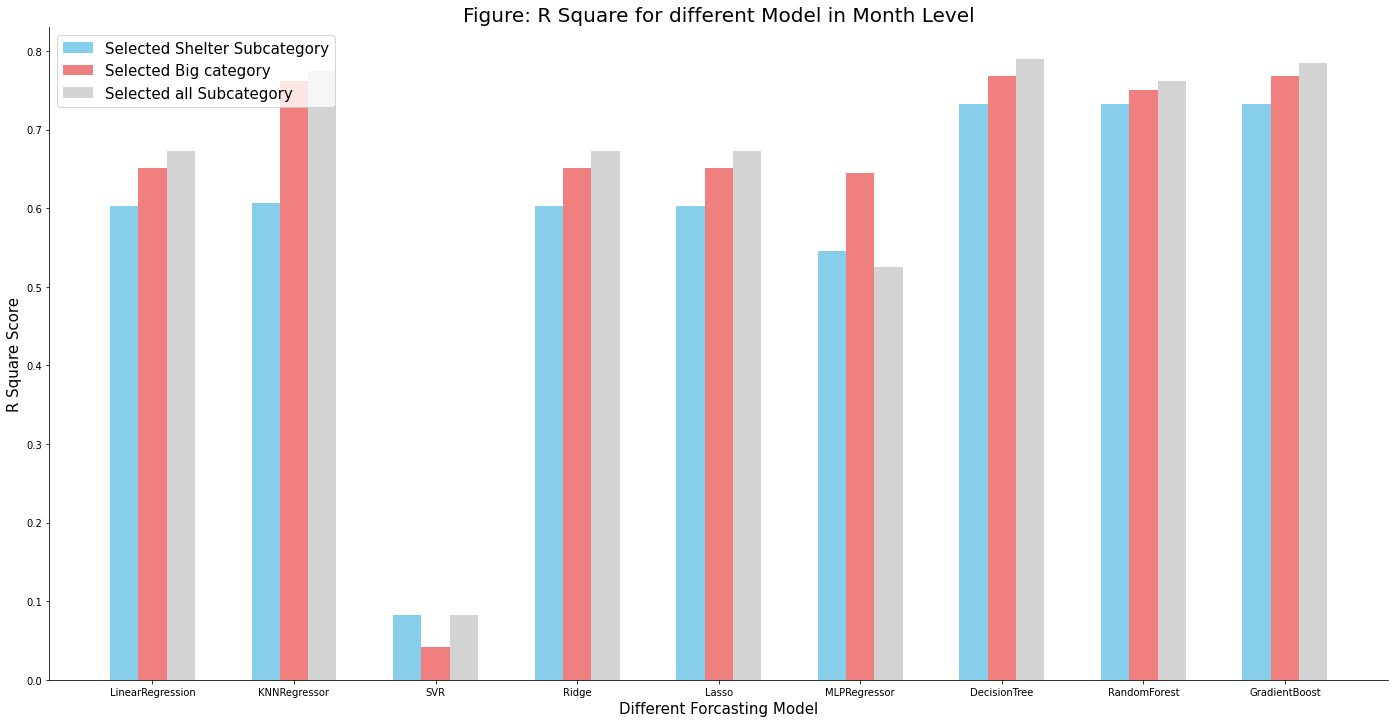

In [164]:
positive_result = after_lasso_result[after_lasso_result["Score"] >= 0]
Columns = list(positive_result["Selected Columns"].drop_duplicates())
Model = list(positive_result["Model Name"].drop_duplicates())
filter1 = after_lasso_result["Model Name"].isin(Model)
tmp = after_lasso_result[filter1]
filter2 = after_lasso_result["Selected Columns"].isin(Columns)
plot_filter = tmp[filter2]
plot_filter.loc[~(plot_filter['Score'] > 0), 'Score'] = -0.01
selected_column = dict()
selected_column["Selected Shelter Subcategory"] = list(plot_filter[plot_filter["Selected Columns"] == "Selected Shelter Subcategory"]["Score"])
selected_column["Selected Big category"] = list(plot_filter[plot_filter["Selected Columns"] == "Selected Big category"]["Score"])
selected_column["Selected all Subcategory"] = list(plot_filter[plot_filter["Selected Columns"] == "Selected all Subcategory"]["Score"])

x=np.arange(9)
bar_width = 1/5
tick_label = list(plot_filter["Model Name"].drop_duplicates())
times = 0
color=['skyblue', 'lightcoral', "lightgrey"]
plt.figure(figsize=(24,12))
for key, value in selected_column.items():
    plt.bar(x + bar_width*times,value,bar_width,color=color[times],label=key)
    times += 1


plt.legend(loc="upper left", fontsize = 10)
plt.xticks(x+bar_width,tick_label)
plt.title("Figure: R Square for different Model in Month Level", fontsize=20)
plt.ylabel("R Square Score", fontsize=15)
plt.xlabel("Different Forcasting Model", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(loc=2, prop={'size': 15})

### Question: use previous filled/jugment number to predict current Filled/Judgment number

In [65]:
filled_judgment_per_month = calls_and_cases_month[["DATE", "Filled", "Judgement"]]
outlier = filled_judgment_per_month[(filled_judgment_per_month.DATE == 'Jul 2019')].index
filled_judgment_per_month = filled_judgment_per_month.drop(outlier)
filled_judgment_per_month['DATE'] = pd.Categorical(filled_judgment_per_month['DATE'], categories=months_by_year, ordered=True)
filled_judgment_per_month.sort_values(by='DATE',ascending=True,inplace=True)
filled_judgment_per_month

,DATE,Filled,Judgement
2,Aug 2019,2667,367
22,Sep 2019,2388,389
20,Oct 2019,2589,413
18,Nov 2019,2116,326
4,Dec 2019,2148,308
8,Jan 2020,2755,327
6,Feb 2020,2152,277
14,Mar 2020,1084,151
0,Apr 2020,54,45
16,May 2020,365,36


Text(0.5, 1.0, 'Figure: Filled and Judgment from Aug 2019 to Oct 2021')

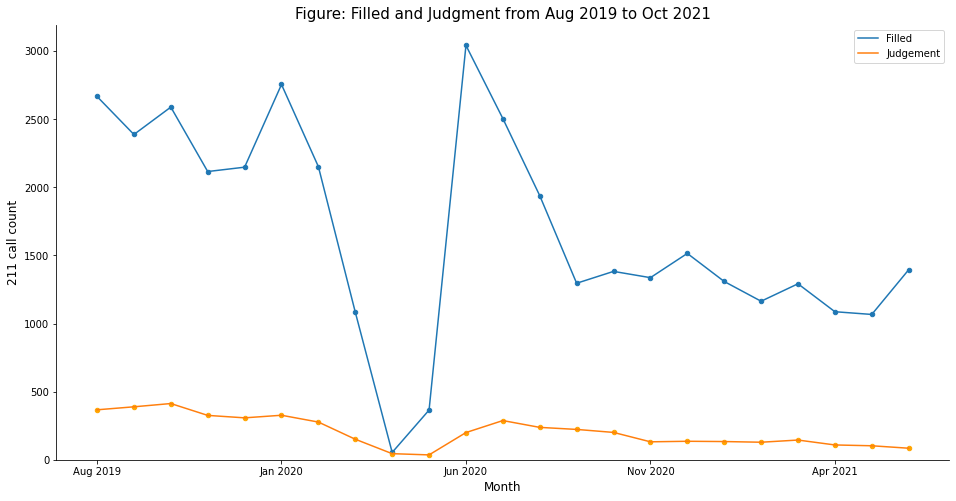

In [66]:
filled_and_judgment = filled_judgment_per_month.plot.line(x="DATE", y= ["Filled", "Judgement"], figsize = (16, 8))
filled_judgment_per_month.plot.scatter(ax = filled_and_judgment, x="DATE", y= "Filled", legend = False, figsize = (16, 8))
filled_judgment_per_month.plot.scatter(ax = filled_and_judgment, x="DATE", y= "Judgement", legend = False, figsize = (16, 8), color = "orange")
filled_and_judgment.spines["top"].set_visible(False)
filled_and_judgment.spines["right"].set_visible(False)
filled_and_judgment.set_ylim(0)
filled_and_judgment.set_ylabel("211 call count", fontsize= 12)
filled_and_judgment.set_xlabel("Month", fontsize= 12)
filled_and_judgment.set_title("Figure: Filled and Judgment from Aug 2019 to Oct 2021", fontsize=15)